In [1]:
%run ../_preamble.ipynb
from _work.src.modules import AutoEncoder, train_model, plot_metrics, plot_tensor, eval_model, get_distances, get_closest_item
from _work.src.modules.replay import get_attractors, iterate
from _work.src.modules.utils import save_metrics, load_metrics
from _work.src.data import small_dataloader as dataloader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

palette = {
    'Oak': '#B0E65A',
    'Pine': '#75993C',
    'Daisy': '#FEB756',
    'Rose': '#E6634E',
    'Salmon': '#9194E3',
    'Sunfish': '#8BCBD9',
    'Canary': '#FFD92F',
    'Robin': '#FF8C9A',
}

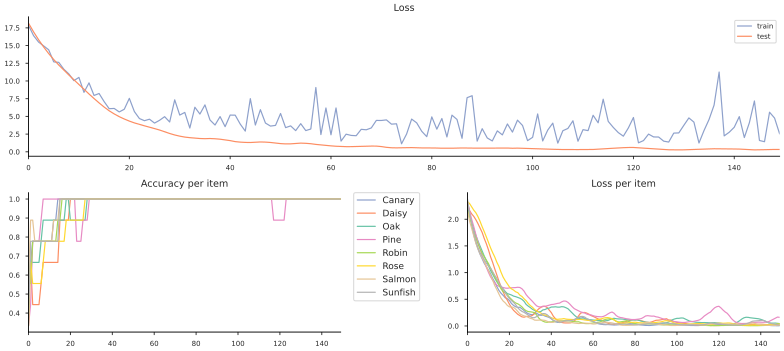

In [3]:
metrics1 = train_model(
    model1 := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32], batch_norm=False, dropout=0),
    optimizer1 := torch.optim.AdamW(model1.parameters(), lr=1e-2),
    loss_fn1 := torch.nn.MSELoss(reduction="sum"),
    dataloader,
    epochs=150,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
    l1_lambda=0.0005,
)

plot_metrics(metrics1);

('Sunfish', 0.15957978316849838)
('Canary', 0.0907597461583724)
('Daisy', 0.18375033207237826)
('Salmon', 0.15837189172325264)
[4191 3614 2880 2260]


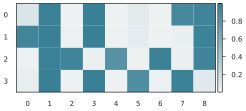

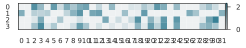

In [4]:
(attractor_states, st_counts), (attractor_activs, _) = get_attractors(
    model1,
    runs=500,
    steps=50,
    burn_in_time=25,
    states_or_activations="states",
    min_occurrence=5,
    round=True,
)
plot_tensor(attractor_states);
for st in attractor_states:
    print(get_distances(st, dataloader.dataset.df, metric='euclidean')[0])
print(st_counts)
plot_tensor(attractor_activs);

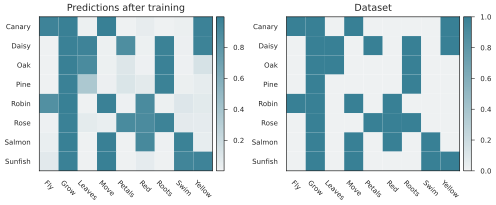

In [5]:
with plt.style.context({ 'figure.figsize': (7, 7) }):
    eval_model(model1, dataloader)

In [182]:
from torch.utils.data import Dataset, DataLoader
from _work.src.modules.replay import iterate


def generate_patterns(model, n_runs=1, n_steps=10, take_last=1, mean=0, stdev=1, multiplier=1):
    assert take_last <= n_steps

    states, _ = iterate(model, runs=n_runs, steps=n_steps, mean=mean, stdev=stdev, multiplier=multiplier)
    states = torch.vstack(tuple(states[:, -take_last:, :]))

    return states # n_runs * take_last


def create_dataloaders(states, n_epochs):
    class ReplayDataset(Dataset):
        def __init__(self, data):
            super().__init__()
            self.data = data
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, i):
            return {
                'y': self.data[i],
            }

    dataloaders = []
    for _ in range(n_epochs):
        indices = np.random.choice(list(range(len(states))), size=8, replace=False)
        data = ReplayDataset(states[indices])
        dl = DataLoader(data, shuffle=True, batch_size=4)
        dataloaders.append(dl)
    
    return dataloaders

In [183]:
def plot_patterns(patterns):
    distdict = {}
    for item in dataloader.dataset.df.index:
        # distdict[item] = []
        distdict[item] = 0
    for pattern in patterns:
        dists = get_distances(pattern, dataloader.dataset.df, metric='euclidean')
        for i, (item, dist) in enumerate(dists):
            # distdict[item].append(dist)
            if i == 0:
                distdict[item] += 1
    
    return distdict
    plt.bar(means.keys(), means.values(), color=[palette[x] for x in dataloader.dataset.df.index]);

In [184]:
nodict = plot_patterns(nopatterns := generate_patterns(
    model1,
    n_runs=1000,
    n_steps=20,
    take_last=15,
    mean=None,
    stdev=None,
    multiplier=0.5,
))

yesdict = plot_patterns(yespatterns := generate_patterns(
    model1,
    n_runs=1000,
    n_steps=20,
    take_last=15,
    mean=0,
    stdev=0.5,
    multiplier=0.5,
))

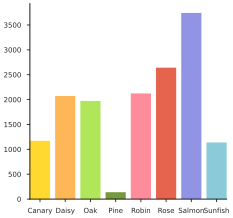

In [185]:
plt.bar(nodict.keys(), nodict.values(), color=[palette[x] for x in dataloader.dataset.df.index]);

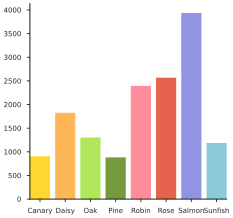

In [186]:
plt.bar(yesdict.keys(), yesdict.values(), color=[palette[x] for x in dataloader.dataset.df.index]);

In [187]:
nodls = create_dataloaders(nopatterns, 1500)
yesdls = create_dataloaders(yespatterns, 1500)

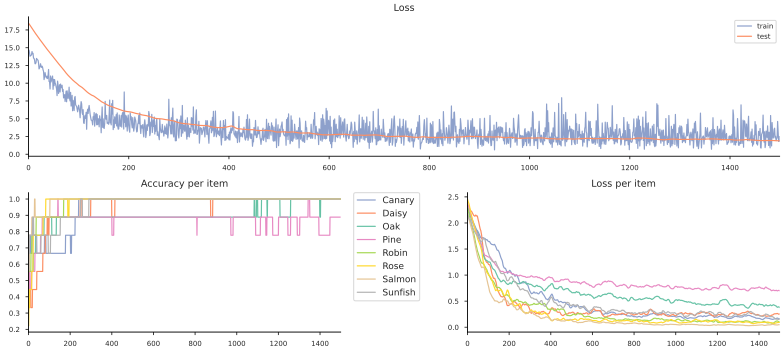

In [188]:
metrics2 = train_model(
    model2 := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32], batch_norm=False, dropout=0),
    optimizer2 := torch.optim.AdamW(model2.parameters(), lr=1e-3),
    loss_fn2 := torch.nn.MSELoss(reduction="sum"),
    nodls,
    test_loader=dataloader,
    epochs=1500,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
    l1_lambda=0.0005,
)

plot_metrics(metrics2);

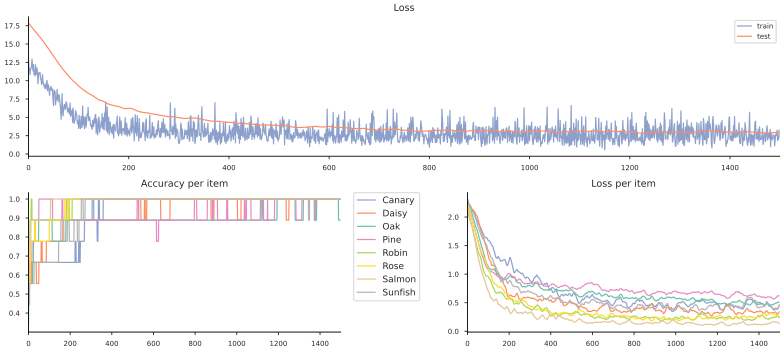

In [189]:
metrics3 = train_model(
    model3 := AutoEncoder(sizes=[dataloader.dataset.NUM_ATTRIBUTES, 32], batch_norm=False, dropout=0),
    optimizer3 := torch.optim.AdamW(model3.parameters(), lr=1e-3),
    loss_fn3 := torch.nn.MSELoss(reduction="sum"),
    yesdls,
    test_loader=dataloader,
    epochs=1500,
    noise_mean=0,
    noise_stdev=1,
    noise_multiplier=0.5,
    l1_lambda=0.0005,
)

plot_metrics(metrics3);

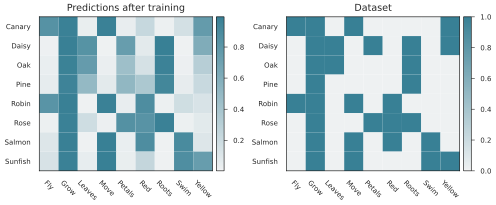

In [190]:
with plt.style.context({ 'figure.figsize': (7, 7) }):
    eval_model(model2, dataloader);

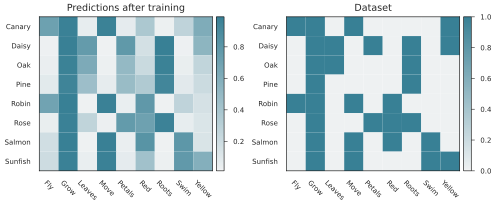

In [191]:
with plt.style.context({ 'figure.figsize': (7, 7) }):
    eval_model(model3, dataloader);